# Информация об оплате (payments_olist_public_dataset.csv)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import sys, os
import pathlib
from pathlib import Path
from pydantic import ValidationError
from olist_churn_prediction.paths import SRC_DIR, PROCESSED_DIR, INTERIM_DIR

In [2]:
sys.path.append(str(SRC_DIR))

In [3]:
from olist_churn_prediction import feature_processing
from olist_churn_prediction.schemas_raw import PaymentsSchemaRaw
from olist_churn_prediction.paths import RAW_DIR

TypeError: type 'Series' is not subscriptable

In [4]:
df = pd.read_csv(RAW_DIR / "payments_olist_public_dataset.csv", low_memory=False)

for i, row in df.head(5).iterrows():
    try:
        PaymentsSchemaRaw.model_validate(row.to_dict())
    except ValidationError as e:
        print(f"\nRow {i}:\n{e}\n")

In [5]:
payments = feature_processing.load_data(RAW_DIR / "payments_olist_public_dataset.csv",
                      schema = PaymentsSchemaRaw,
                      validate = True) 

In [6]:
display(payments.head())
print(payments.shape)
payments.dtypes

,order_id,installments,sequential,payment_type,value
0,25e8ea4e93396b6fa0d3dd708e76c1bd,1,1,credit_card,65.709999
1,ba78997921bbcdc1373bb41e913ab953,8,1,credit_card,107.779999
2,42fdf880ba16b47b59251dd489d4441a,2,1,credit_card,128.449997
3,771ee386b001f06208a7419e4fc1bbd7,1,1,credit_card,81.160004
4,62fe0bd75deb58982ebf8e53a128a301,1,1,credit_card,15.820000


(97433, 5)


order_id        string[python]
installments             Int64
sequential               Int64
payment_type    string[python]
value                  float32
dtype: object

*order_id* - id заказа;

*installments* - количество маленьких платежей после разбития. В случае рассрочки *installments* > 1;

*sequential* - в случае рассрочки: номер платежа в очереди;

*payment_type* - способ оплаты;

*value* - сумма платежа.

In [32]:
print(payments.isna().sum())

order_id        0
installments    0
sequential      0
payment_type    0
value           0
dtype: int64


In [33]:
for col in payments.columns.drop('value'):
    print(f"--- {col} ---")
    print(payments[col].value_counts())
    print()

--- order_id ---
order_id
fa65dad1b0e818e3ccc5cb0e39231352    29
03e1841a170fb6f5e24206904efc6fab    27
41fb7a8d8f3d73458b618d9e8e6acfc5    26
ccf804e764ed5650cd8759557269dc13    26
895ab968e7bb0d5659d16cd74cd1650c    21
                                    ..
29dea474da93a6db101993bd66950030     1
803e822a03730624352b85d6bb2727c3     1
d19f4ab4bd008d9b26f5eb3afc6cc251     1
08155dc6ba79711f958dca6dfa4bbb01     1
fbf642fcdceb367d872ffafae54fc09a     1
Name: count, Length: 93000, dtype: Int64

--- installments ---
installments
1     48376
2     11745
3     10106
4      6806
10     5070
5      4940
8      3933
6      3810
7      1649
9       652
12      129
15       71
11       31
18       29
24       25
20       15
13       12
14       12
16        8
17        4
19        3
22        2
21        2
0         2
23        1
Name: count, dtype: Int64

--- sequential ---
sequential
1     92928
2      2939
3       583
4       295
5       177
6       118
7        83
8        59
9        50
10  

Удалим строки со значениями installments=0 и value=0:

In [34]:
df = payments.copy()

In [35]:
print(df[df['installments'] == 0])
print(df[df['value'] == 0])

                               order_id  installments  sequential  \
44043  744bade1fcf9ff3f31d860ace076d422             0           2   
74314  1a57108394169c0b47d8f876acc9ba2d             0           2   

      payment_type       value  
44043  credit_card   58.689999  
74314  credit_card  129.940002  
                               order_id  installments  sequential  \
34402  fa65dad1b0e818e3ccc5cb0e39231352             1          14   
58923  45ed6e85398a87c253db47c2d9f48216             1           3   
73231  fa65dad1b0e818e3ccc5cb0e39231352             1          13   

      payment_type  value  
34402      voucher    0.0  
58923      voucher    0.0  
73231      voucher    0.0  


In [36]:
df = df.drop(df[df['installments'] == 0].index)

In [37]:
df = df.drop(df[df['value'] == 0].index)

<Axes: xlabel='value', ylabel='Count'>

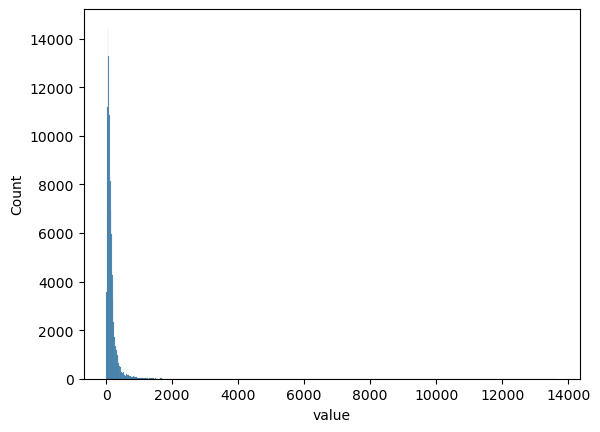

In [38]:
sns.histplot(data=df, x='value')

## Выводы из таблицы payments:
1. Большинство людей предпочитают платить кредитной картой или boleto - бразильский аналог наличного ваучера.
2. Почти все суммы платежей лежат в диапазоне от 0 до 1000.
3. Более половины клиентов предпочитают платить одним платежом, а не в рассрочку.

In [39]:
df.to_parquet(INTERIM_DIR / "payments_olist_public_dataset_interim.parquet", index=False)